In [1]:
import pandas as pd
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.lines import Line2D

In [2]:
retained_cols = ["suburb", "suburb_code", "immigration_2016", "immigration_2017", "immigration_2018", "immigration_2019", 
                 "immigration_2020"]
immigration_df = pd.read_csv("../data/curated/Population.csv", usecols=retained_cols)

immigration_df = pd.melt(immigration_df, id_vars=["suburb", "suburb_code"])

# Create year column 
for i in range(len(immigration_df)):
    if immigration_df.loc[i, "variable"] == "immigration_2016":
        immigration_df.loc[i, "year"] = 2016
    elif immigration_df.loc[i, "variable"] == "immigration_2017":
        immigration_df.loc[i, "year"] = 2017
    elif immigration_df.loc[i, "variable"] == "immigration_2018":
        immigration_df.loc[i, "year"] = 2018
    elif immigration_df.loc[i, "variable"] == "immigration_2019":
        immigration_df.loc[i, "year"] = 2019
    elif immigration_df.loc[i, "variable"] == "immigration_2020":
        immigration_df.loc[i, "year"] = 2020

# Predict immigration count for 2021
sa2_list = [i for i in immigration_df["suburb"].unique()]
immigration_predictions = pd.DataFrame(columns =["suburb", "lower value", "upper value", "predictions"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for i in sa2_list:
        curr_suburb = immigration_df[immigration_df["suburb"] == i]
        y = curr_suburb["value"]

        ARMAmodel = SARIMAX(y, order=(1,0,1))
        ARMAmodel = ARMAmodel.fit(disp=0)

        y_pred = ARMAmodel.get_forecast(1)
        y_pred_df = y_pred.conf_int(alpha=0.05) 
        y_pred_df["predictions"] = ARMAmodel.predict(start=y_pred_df.index[0], end=y_pred_df.index[-1])
        y_pred_df["year"] = 2021

        y_pred_df["suburb"] = i 
        
        immigration_predictions = pd.concat([immigration_predictions, y_pred_df])
    
# Combine sourced and predicted immigration data
immigration_predictions = immigration_predictions.rename(columns={"predictions": "value"}).drop(["lower value", "upper value"], axis=1).reset_index(drop=True)
immigration_df = immigration_df.drop(["suburb_code", "variable"], axis=1).reset_index(drop=True)
immigration_df = pd.concat([immigration_df, immigration_predictions], ignore_index=True)

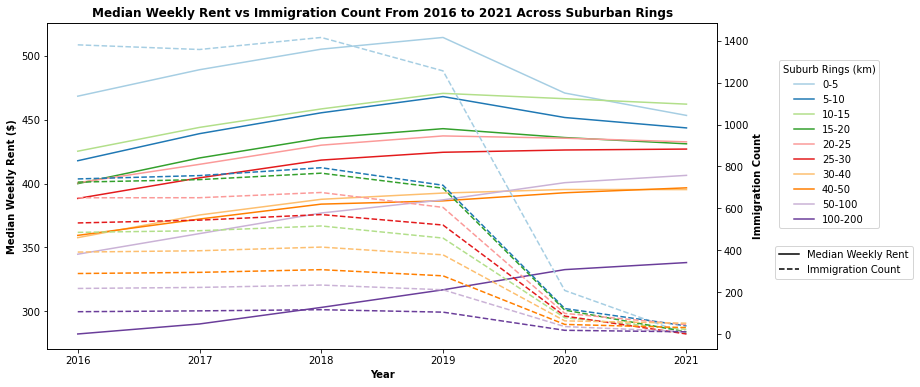

In [3]:
# Set negative immigration count to 0
immigration_df.loc[immigration_df["value"] < 0, "value"] = 0
final_immigration_df = immigration_df.copy()

# Save immigration dataframe as csv file
pivot_immigration_df = immigration_df.copy()
pivot_immigration_df = pivot_immigration_df.pivot_table(index="suburb", columns="year", values="value").reset_index()
pivot_immigration_df.to_csv("../data/curated/Immigration.csv", index=False)

rental_df = pd.read_csv("../data/curated/Final_Preprocessed_Scraped_Rental.csv")
historical_rental_df = pd.read_csv("../data/curated/Fixed_Weekly_Median_Suburb_Rents.csv")

# Filter instances from 2016-2021
historical_rental_df = historical_rental_df[historical_rental_df["Year"] >= 2016] 

# Convert suburb names to lowercase
historical_rental_df["Suburb"] = historical_rental_df["Suburb"].str.lower()

# Group instances by year and suburb in historical rental dataset
historical_rental_df = historical_rental_df.groupby(["Year", "Suburb"], as_index=False)["Median"].mean()

# Compute distance to CBD for each suburb in the immigration dataset
distance_to_cbd_df = rental_df.groupby("suburb", as_index=False)["distance_to_cbd"].mean()
final_immigration_df = final_immigration_df.groupby(["year", "suburb"], as_index=False)["value"].mean()
final_immigration_df = pd.merge(final_immigration_df, distance_to_cbd_df, on="suburb")
final_immigration_df = pd.merge(final_immigration_df, historical_rental_df, left_on=["suburb", "year"], right_on=["Suburb", "Year"]).drop(["Year", "Suburb"], axis=1)

# Bin suburbs based on distance to CBD
final_immigration_df["bins"] = pd.cut(final_immigration_df["distance_to_cbd"], [0, 5, 10, 15, 20, 25, 30, 40, 50, 100, 200], 
                         labels=["0-5", "5-10", "10-15", "15-20", "20-25", "25-30", "30-40", "40-50", "50-100", "100-200"])

# Group instances by year and distance to CBD bins
final_immigration_df = final_immigration_df.groupby(["year", "bins"], as_index=False)[["Median", "value"]].mean().copy()

# Create line plot for median weekly rent from 2016-2021 across suburban rings
fig = plt.figure()
ax = fig.add_subplot()
ax = sns.lineplot(data=final_immigration_df, x="year", y="Median", hue="bins", palette="Paired", err_style=None)
ax.set_xlabel("Year", fontweight="bold")
ax.set_ylabel("Median Weekly Rent ($)", fontweight="bold")
plt.legend(title="Suburb Rings (km)", loc="upper right", bbox_to_anchor=(1.25, 0.9), 
           labels=["0-5", "5-10", "10-15", "15-20", "20-25", "25-30", "30-40", "40-50", "50-100", "100-200"])

# Create line plot for immigration count from 2016-2021 across suburban rings
ax_second = ax.twinx()
ax_second = sns.lineplot(data=final_immigration_df, x="year", y="value", hue="bins", palette="Paired", linestyle="--", legend=False, err_style=None)
ax_second.set_ylabel("Immigration Count", fontweight="bold")
line = Line2D([0,1],[0,1],linestyle="-", color="black")
line2 = Line2D([0,1],[0,1],linestyle="--", color="black")
ax_second.legend([line, line2],["Median Weekly Rent", "Immigration Count"], loc="lower right", bbox_to_anchor=(1.3, 0.2))
plt.title("Median Weekly Rent vs Immigration Count From 2016 to 2021 Across Suburban Rings", fontweight="bold")
fig.set_size_inches(12,6)
plt.savefig("../plots/median_weekly_rent_immigration_count_double_line_plot.png", transparent=True, facecolor="white", bbox_inches="tight")
plt.show()
plt.close()

C:\Users\benja\AppData\Local\Temp/ipykernel_17704/3811064669.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.set_yticklabels(fig.get_yticks(), size=20)


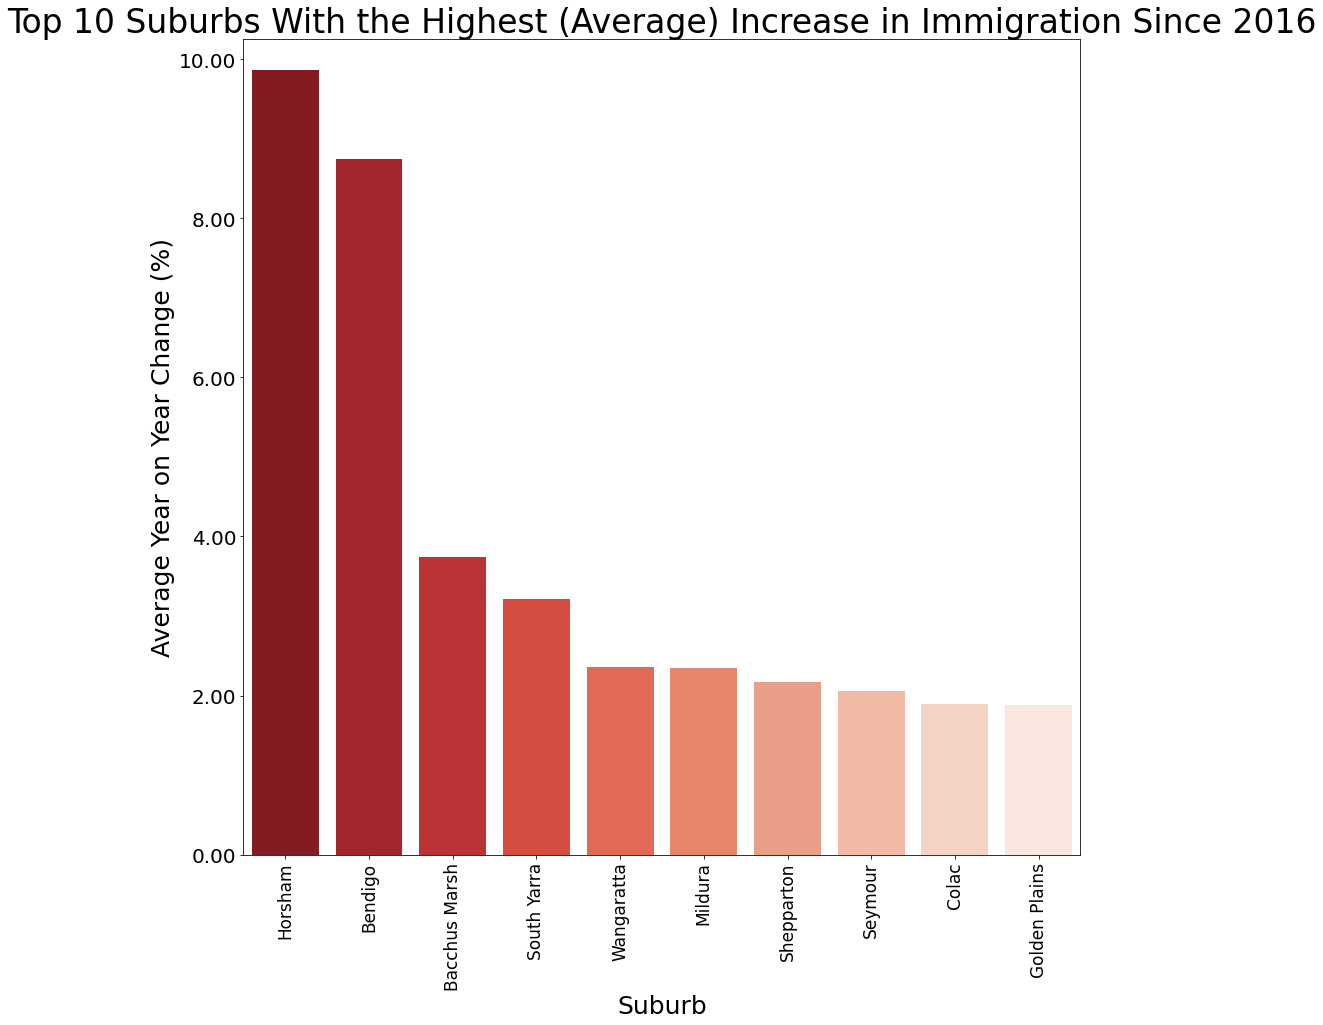

In [4]:
# Calculate average percentage change in immigration by suburb
percentage_changes = immigration_df.copy()
percentage_changes.sort_values(["suburb", "year"], inplace=True, ascending=[True, True])
percentage_changes["percentage_change"] = (percentage_changes.groupby("suburb")["value"].apply(pd.Series.pct_change) + 1)
percentage_changes_mean = percentage_changes.groupby(["suburb"], as_index=False).mean().sort_values(by=["percentage_change"], ascending=False)

# Capitalise suburb names
percentage_changes_mean["suburb"] = percentage_changes_mean["suburb"].str.title()

# Obtain top ten suburbs with highest and lowest average percentage change in immigration respectively
percentage_changes_mean = percentage_changes_mean.dropna().reset_index(drop=True)
top_ten = percentage_changes_mean.head(10).reset_index(drop=True)
bottom_ten = percentage_changes_mean.tail(10).reset_index(drop=True)

# Create bar plot for top ten suburbs with highest average percentage change in immigration
plt.figure(figsize=(15,15))
fig = sns.barplot(data=top_ten, x="suburb", y="percentage_change", palette="Reds_r", dodge=False)
fig.set(ylim=(0.0000, 10.2500))
fig.set_xlabel("Suburb", size=25)
fig.set_ylabel("Average Year on Year Change (%)", size=25)

fig.set_xticklabels([i for i in top_ten["suburb"]], size=17, rotation=90)
fig.set_yticklabels(fig.get_yticks(), size=20)
fig.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
fig.set_title("Top 10 Suburbs With the Highest (Average) Increase in Immigration Since 2016", size=33)
plt.savefig("../plots/top_ten_increase_immigration.png", transparent=True, facecolor="white", bbox_inches="tight")
plt.show()
plt.close()

C:\Users\benja\AppData\Local\Temp/ipykernel_17704/2928084197.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.set_yticklabels(fig.get_yticks(), size=20)


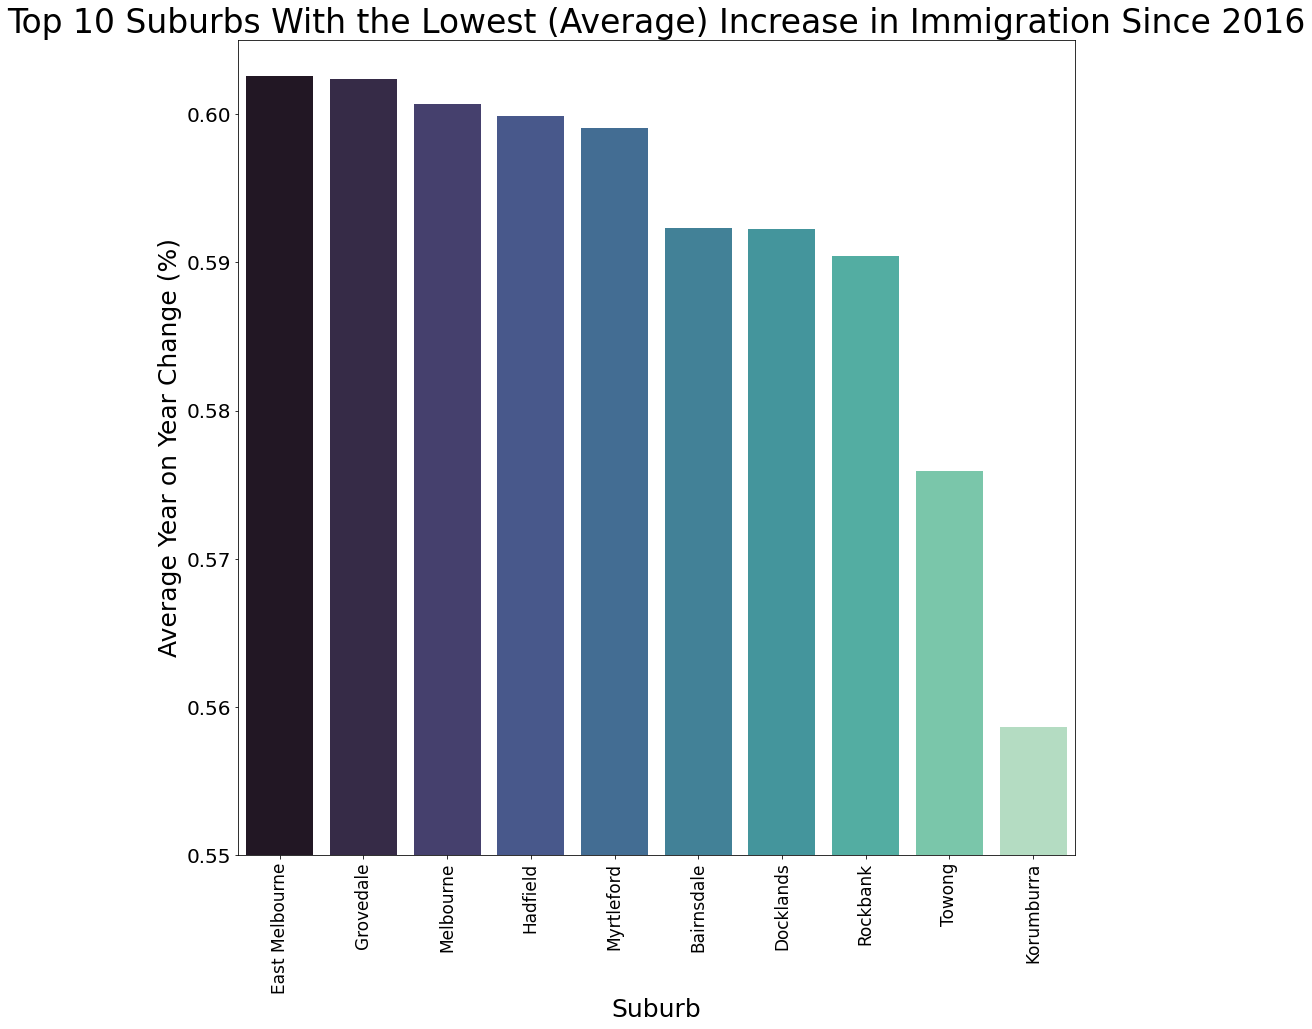

In [5]:
# Create bar plot for top ten suburbs with lowest average percentage change in immigration
plt.figure(figsize=(15,15)) 
fig = sns.barplot(data=bottom_ten, x="suburb", y="percentage_change", palette="mako", dodge=False)
fig.set(ylim=(0.5500, 0.6050))
fig.set_xlabel("Suburb", size=25)
fig.set_ylabel("Average Year on Year Change (%)", size=25)

fig.set_xticklabels([i for i in bottom_ten["suburb"]], size=17, rotation=90)
fig.set_yticklabels(fig.get_yticks(), size=20)
fig.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
fig.set_title("Top 10 Suburbs With the Lowest (Average) Increase in Immigration Since 2016", size=33)
plt.savefig("../plots/bottom_ten_increase_immigration.png", transparent=True, facecolor="white", bbox_inches="tight")
plt.show()
plt.close()